#### Compare ERA5 and CONUS404 TWB.
The CONUS404 data are at https://rda.ucar.edu/datasets/ds559.0/
 
 https://www.youtube.com/watch?v=7RlkV3022ys
 https://github.com/zxdawn/GEOSChem-python-tutorial/blob/master/Chapter04_regridding_WRFChem.ipynb
 https://github.com/geoschem/GEOSChem-python-tutorial
 
 a) remapping using bilinear interpolation to a gaussian (128x64) grid 
 cdo remapbil,n32 wrfout_d01_1999-01-01-01_00:00:00.nc out.nc
 b) Here's an example remapping using nearest neighbor mapping to one latitude,longitude point:

cdo remapnn,lon=-107.0_lat=34.0 wrfout_d01_1999-01-01-01_00:00:00.nc out.nc

#### 1) extract hourly timeseries of ERA5 and WRFCONUS at Yuma AZ
 - 1.1) get lat-lon of Yuma, AZ usging geolocator
 - 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)
 - 1.3) extract hourly data time series from unstructured grid WRF CONUS404
 - 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 
 
#### 2) mash plot days > 90 percentile.

In [21]:
import os.path
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import geopy
import scipy
from scipy.interpolate import griddata
from geopy.geocoders import Nominatim

In [22]:
def find_indices(points,lon,lat,tree=None):
    if tree is None:
        lon,lat = lon.T,lat.T
        lonlat = np.column_stack((lon.ravel(),lat.ravel()))
        tree = scipy.spatial.cKDTree(lonlat)
    dist,idx = tree.query(points,k=1)
    ind = np.column_stack(np.unravel_index(idx,lon.shape))
    return [(i,j) for i,j in ind]

def cal_p90_df(flnm):
    '''
    flnm: input hourly time series file name
    return P90 of daily maximum and daily maximum timeseries   
    '''
    print(flnm)
    df = pd.read_csv(flnm, index_col = 0)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    df_dmax = df.resample('D').max()
    
    # calculate quantile over requested axis
    p90_tmax = df_dmax.quantile(.9, axis = 0)
     
    print('--')
    return p90_tmax, df_dmax

def mask_perc(df, column, perc):
    '''
    mask values less that perc
    df: dataFrame
    column: the column to mask
    perc:  percentile value
    '''
    itt = df.index[df[column] < perc]
    # Make a copy of this object’s indices and data.
    # deep=True (default)
    ts_series = df[column].copy()
    ts_series[itt] = np.nan
    return ts_series

In [24]:
dir_c = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/'
dir_e = '/glade/campaign/mmm/c3we/wetbulb/'
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

year_s = 1980
year_e = 2020
 
n_year = year_e - year_s + 1
n_366 = 366

StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
TimeHH   = pd.date_range(StartDay, end=StopDay, freq='1h')
print('n_hours:', len(TimeHH), ' between', StartDay, 'and', StopDay)

n_hours: 359424  between 1980-01-01 00:00:00 and 2020-12-31 23:00:00


#### 1.1) get lat-lon of Yuma, AZ usging geolocator

In [25]:
# Create a geolocator object using the Openstreet Nominatim API. 
# It’s a good idea to increase the default timeout setting from 1s to 10s 
# so that you don’t get a TimedOut exception. 
# You’ll also need to enter a name (any name) for the ‘user_agent’ attribute.
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
#loc = geolocator.geocode('Yuma' + ','+ 'US')
loc = geolocator.geocode('Yuma, US')
lat_pt = loc.latitude
lon_pt = loc.longitude

points = ([[lon_pt, lat_pt]])

#points = np.array([lon_pt, lat_pt]).transpose() 
print(points)

[[-114.47603157249804, 32.665135]]


#### 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)

In [26]:
# a test
flnm_c =  dir_c + 'TWB_202012_CONUS404.nc' 
print(flnm_c)

with  xr.open_dataset(flnm_c) as ds:
    Lat = ds.lat.to_numpy()
    Lon = ds.lon.to_numpy()    
    ind = find_indices(points, Lon, Lat,tree=None)[0]
    print('model Lon-Lat', Lon[ind[1],ind[0]], Lat[ind[1],ind[0]], 'vs actual lon_lat', points)

/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/TWB_202012_CONUS404.nc
model Lon-Lat -114.47633 32.65857 vs actual lon_lat [[-114.47603157249804, 32.665135]]


#### 1.3) extract hourly data time series from  unstructured grid WRF CONUS404 

In [27]:
flnm_ow = dir_o + 'twb_yuma_conus404.csv'

if os.path.exists(flnm_o): 
    print(flnm_o, 'exist')
    df_w = pd.read_csv(flnm_o, index_col = 0)    
else:       
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            flnm = dir_c + 'TWB_' + str(year) + str(month).zfill(2) + '_CONUS404.nc' 
        
            with xr.open_dataset(flnm) as ds:
                print('FILE=', flnm)                
                var = ds['TWB'][:, ind[1],ind[0] ]
            if year == year_s and month == 1:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
 
    print(flnm_o)
    df.to_csv(flnm_o)  
    print('SUCCEED')  
    
#df_w.plot(title='Yuma')

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era.csv exist


#### 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 

In [28]:
flnm_oe = dir_o + 'twb_yuma_era.csv'
print(flnm_o)
if os.path.exists(flnm_o): 
    print(flnm_o, 'exist')
    df_e = pd.read_csv(flnm_o, index_col = 0)  
else:       
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            flnm_e = dir_e + 'TWB_' + str(year) + str(month).zfill(2) + '.nc' 
            with xr.open_dataset(flnm_e) as ds:
                print('FILE=', flnm_e)                
                var = ds['TWB'].sel(latitude=lat_pt, longitude=lon_pt+360, method="nearest").values
            if year == year_s and month == 1:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
 
    print(flnm_o)
    df.to_csv(flnm_o)  
    print('SUCCEED')  

#df_e.plot(title='Yuma')

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era.csv exist


#### 2) Calculate annual # days > 90 percentile.

In [12]:
n_366 = 366
arr_2d = np.empty((n_year, n_366))
arr_2d[:] = np.nan

# the outputs of meshgrid are of shape (N, M) for ‘xy’ indexing and (M, N) for ‘ij’ indexing.
# default 'xy' indexing
day_2d, year_2d = np.meshgrid(range(1, n_366+1), range(year_s, year_e+1))

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404.csv
--
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era.csv
--


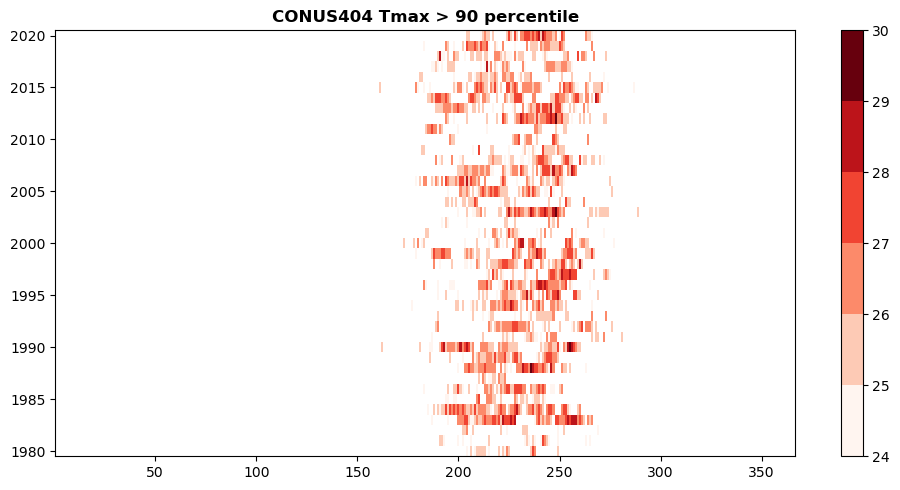

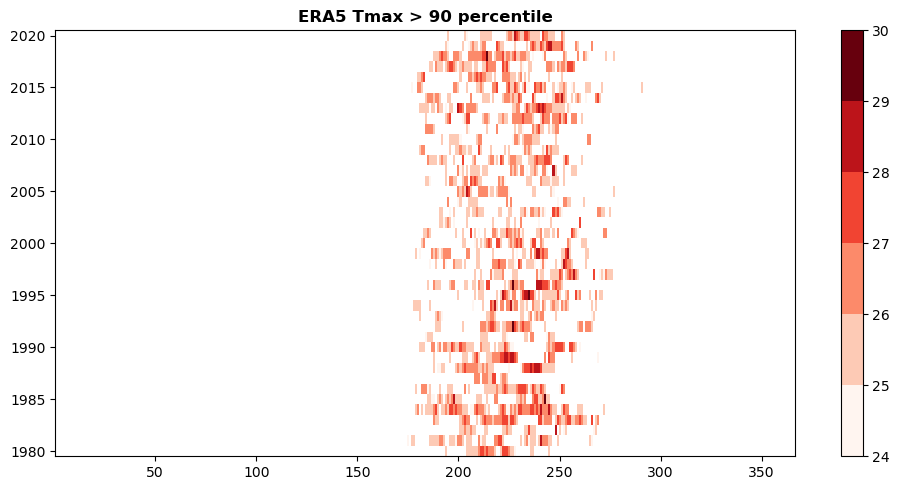

In [43]:
flnm_1d = [flnm_ow, flnm_oe]
title_1d = ['CONUS404', 'ERA5']

nn = 0
for flnm in flnm_1d:
    fig, ax = plt.subplots(1,1,figsize=(10, 5)) 
    p90_tmax, df_dmax = cal_p90_df(flnm)
    
    data = {'year': pd.DatetimeIndex(df_dmax.index).year,
            'Yuma': mask_perc(df_dmax, 'Yuma', p90_tmax['Yuma'])}
    
    df_new = pd.DataFrame(data)
    
    for year in range(year_s, year_e+1):
            iTT = np.isin(df_new.year, year)
            # by adding [0] in id_iTT, convert tuple -> numpy.ndarray
            id_iTT = np.where(iTT == True)[0] 
         
            arr_2d[year-year_s, :len(id_iTT)] = df_new['Yuma'][id_iTT]       
    if nn == 0 :
        arr_2d = arr_2d - 273.15
    # the pcolormesh() method to create a pseudocolor plot with a non-regular rectangular grid.
    # use the plt.cm.get_cmap() for discret color bars
    im=ax.pcolormesh(day_2d, year_2d, arr_2d, vmin = 24, vmax = 30, cmap=plt.cm.get_cmap('Reds', 6)) 
    cbar = fig.colorbar(im, ax=ax)
    ax.set_title(title_1d[nn] + ' Tmax > 90 percentile', fontweight ="bold")
    nn = nn + 1    
    plt.tight_layout()
     